# Project Title: Financial Market Data Analysis Toolkit Part 4 - ARIMA Forecasting

**Author:** Siddhant Dhoot

[LinkedIn](https://www.linkedin.com/in/siddhantdhoot/)

**Date:** June 27, 2025

**Description:** A Python script to build, evaluate, and interpret an ARIMA (AutoRegressive Integrated Moving Average) model to forecast the daily returns of a major stock market index.

**Purpose:** To practice the end-to-end methodology of statistical time series forecasting. This includes testing for stationarity, interpreting ACF/PACF plots to determine model parameters, fitting the model using the `statsmodels` library, and generating a forecast with confidence intervals.

<h4>Step 1: Import Python liabraries</h4>

In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.tsa.stattools as ts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

<h4>Step 2: Get user input for stock tickers and period of analysis</h4>

In [2]:
input_ticker = input("Enter the ticker: ")
start_date = input("Enter the start date (YYYY-MM-DD): ")
end_date = input("Enter the end date (YYYY-MM-DD): ")

Enter the ticker:  ^GSPC
Enter the start date (YYYY-MM-DD):  2010-01-01
Enter the end date (YYYY-MM-DD):  2025-01-01


<h4>Step 3: Use datetime to convert the start_date to a datetime object. To calculate moving averages accurately, we need data from the period preceding the start date as well. Hence, we use the datetime methods to change the start date.</h4>

In [3]:
format_date = "%Y-%m-%d"
#Create datetime object
start_date = datetime.datetime.strptime(start_date,format_date) 
#Define the period you want to go back
preceding_period = datetime.timedelta(days = 1)
#Move the start date back
start_date_new = start_date - preceding_period
#Convert the datetime object back to string
start_date_new = start_date_new.strftime(format_date)

<h4>Step 4: Create a yfinance object and import historical stock data using the method .history()</h4>

In [10]:
#Create the DataFrame objects 
stock_data = pd.DataFrame()
#Import historical data using .history() and creating a master DataFrame by adding additional columns with closing price for each stock
stock_object = yf.Ticker(input_ticker)
stock_historical = stock_object.history(start = start_date_new, end = end_date, interval="1d")
stock_historical.reset_index(inplace=True)
stock_data = stock_historical[["Date", "Close"]]
stock_data.set_index("Date", inplace=True)
#Display the imported data to confirm
stock_data

,Close
Date,
2009-12-31 00:00:00-05:00,1115.099976
2010-01-04 00:00:00-05:00,1132.989990
2010-01-05 00:00:00-05:00,1136.520020
2010-01-06 00:00:00-05:00,1137.140015
2010-01-07 00:00:00-05:00,1141.689941
...,...
2024-12-24 00:00:00-05:00,6040.040039
2024-12-26 00:00:00-05:00,6037.589844
2024-12-27 00:00:00-05:00,5970.839844


<h4>Step 5: Check for Stationarity</h4>

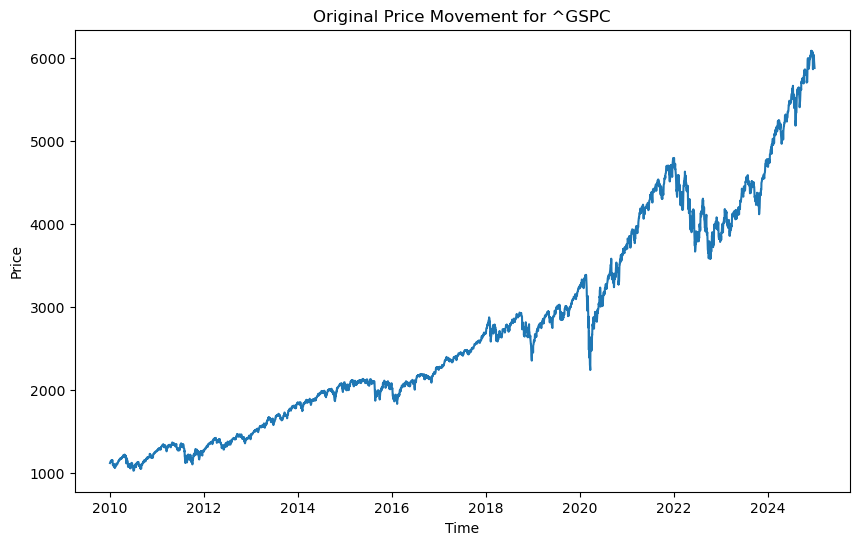

ADF Statistic: 1.372407
p-value: 0.996985
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The time series is non-stationary (fail to reject H0).


In [15]:
#Use matplotlib to create a line graph. Label the graph and its axes appropriately. 
plt.figure(figsize=(10, 6))
plt.plot(stock_data["Close"])
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Original Price Movement for "+input_ticker)
plt.show()

# Perform the ADF test
result = ts.adfuller(stock_data["Close"])

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] > 0.05:
    print("The time series is non-stationary (fail to reject H0).")
else:
    print("The time series is stationary (reject H0).")

It is observable that there is a general upward trend in the time series. Hence, the time series is not stationary.
The same is confirmed using the Augmented Dickey Fuller Test. To perform ARIMA forecasting, a time series has to stationary. 
Therefore, this time series needs to be transformed into a stationary time series. This transformation is the I in ARIMA. 

<h4>Step 6: Transformation into an approximately stationary time series</h4>

C:\Users\siddh\AppData\Local\Temp\ipykernel_32276\669177206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["log_returns"] = np.log(stock_data["Close"] / stock_data["Close"].shift(1))


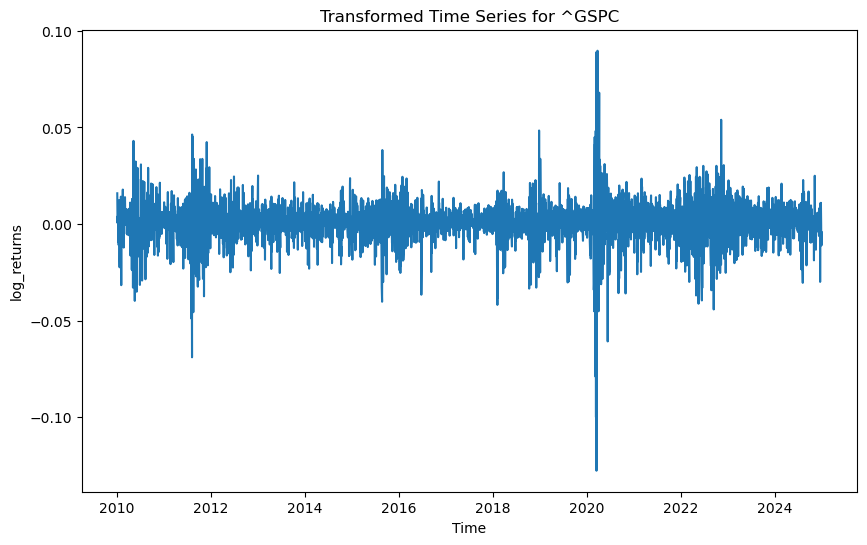

ADF Statistic: -13.356928
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The time series is stationary (reject H0).


In [17]:
#Convert the closing price time series to a log return time series. 
stock_data["log_returns"] = np.log(stock_data["Close"] / stock_data["Close"].shift(1))

# Drop NaN values that result from the shift operation
stock_data = stock_data.dropna()

# Plot the log returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data["log_returns"])
plt.xlabel("Time")
plt.ylabel("log_returns")
plt.title("Transformed Time Series for "+input_ticker)
plt.show()

# Check for any remaining inf values and replace them if necessary
# This step is added to handle any potential inf values from log(0) operations
stock_data = stock_data.replace([np.inf, -np.inf], np.nan).dropna()

# Perform the ADF test
result = ts.adfuller(stock_data["log_returns"])

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] > 0.05:
    print("The time series is non-stationary (fail to reject H0).")
else:
    print("The time series is stationary (reject H0).")

We can see that this transformed time series is much more stationary than the original time series. log return is a common tool used to make financial time series stationary. There are some outliers but the series is largely stationary as confirmed by the ADF test. 

<h4>Step 7: Indentify Potential Model Parameters</h4>

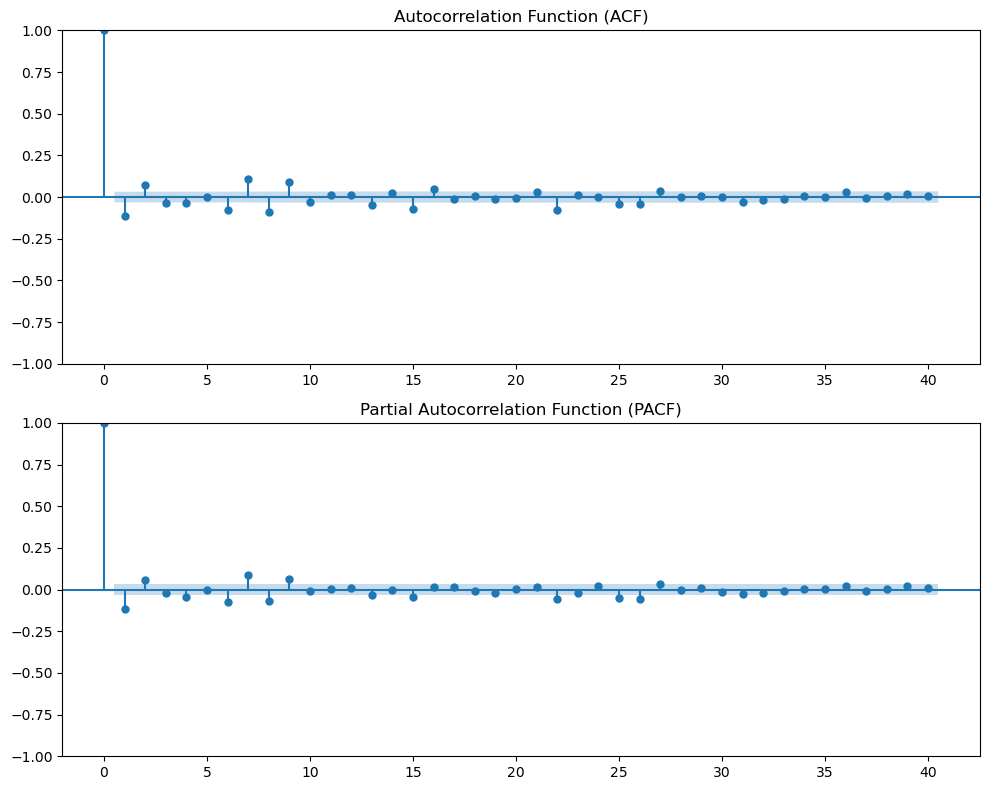

In [27]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot the ACF
plot_acf(stock_data["log_returns"], lags=40, ax=axes[0], title='Autocorrelation Function (ACF)')

# Plot the PACF
plot_pacf(stock_data["log_returns"], lags=40, ax=axes[1], title='Partial Autocorrelation Function (PACF)')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

stock_data.reset_index(inplace=True)

On both graphs, there is only 1 or 2 spikes that are statistically significant. In the coming steps we may want to look at ARIMA models with p (AR) and q (MA) values between 0 and 2. 

<h4>Step 8: Create Training and Testing Datasets. Tryout multiple ARIMA models to test for best fit.</h4>

In [50]:
stock_data_new = stock_data[["log_returns"]]
train_data, test_data = train_test_split(stock_data_new, test_size=0.2, shuffle=False)

# Define ARIMA orders to test
orders = [(0,0,0), (0,0,1), (0,0,2), (1,0,0), (1,0,1), (1,0,2), (2,0,0), (2,0,1), (2,0,2)]

best_aic = float('inf')
best_order = None
best_model = None

for order in orders:
    try:
        # Create and fit the ARIMA model
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()

        # Evaluate using AIC
        aic = model_fit.aic
        print(f'ARIMA{order}: AIC={aic}')

        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model = model_fit


        # Evaluate using out-of-sample validation
        predictions = model_fit.forecast(steps=len(test_data))
        rmse = np.sqrt(mean_squared_error(test_data, predictions))
        print(f'ARIMA{order}: Out-of-sample RMSE={rmse}')


    except Exception as e:
        print(f'ARIMA{order} failed: {e}')

print(f'Best ARIMA order: {best_order} with AIC={best_aic}')

ARIMA(0, 0, 0): AIC=-18737.132104219785
ARIMA(0, 0, 0): Out-of-sample RMSE=0.011008112565744504
ARIMA(0, 0, 1): AIC=-18792.78828774367
ARIMA(0, 0, 1): Out-of-sample RMSE=0.01100805249662527
ARIMA(0, 0, 2): AIC=-18818.634097777758
ARIMA(0, 0, 2): Out-of-sample RMSE=0.011008148636893618
ARIMA(1, 0, 0): AIC=-18803.06842308303
ARIMA(1, 0, 0): Out-of-sample RMSE=0.011008161185622891
ARIMA(1, 0, 1): AIC=-18811.41181403508
ARIMA(1, 0, 1): Out-of-sample RMSE=0.01100803844563226
ARIMA(1, 0, 2): AIC=-18819.696178794118
ARIMA(1, 0, 2): Out-of-sample RMSE=0.011008071847292702
ARIMA(2, 0, 0): AIC=-18820.24693860652
ARIMA(2, 0, 0): Out-of-sample RMSE=0.01100816447028831
ARIMA(2, 0, 1): AIC=-18818.108382750244
ARIMA(2, 0, 1): Out-of-sample RMSE=0.011008123005285723
ARIMA(2, 0, 2): AIC=-18812.55059127182
ARIMA(2, 0, 2): Out-of-sample RMSE=0.011008235296867256
Best ARIMA order: (2, 0, 0) with AIC=-18820.24693860652


<h4>Step 9: Convert everything back to prices. Visualize the forecasted data</h4>

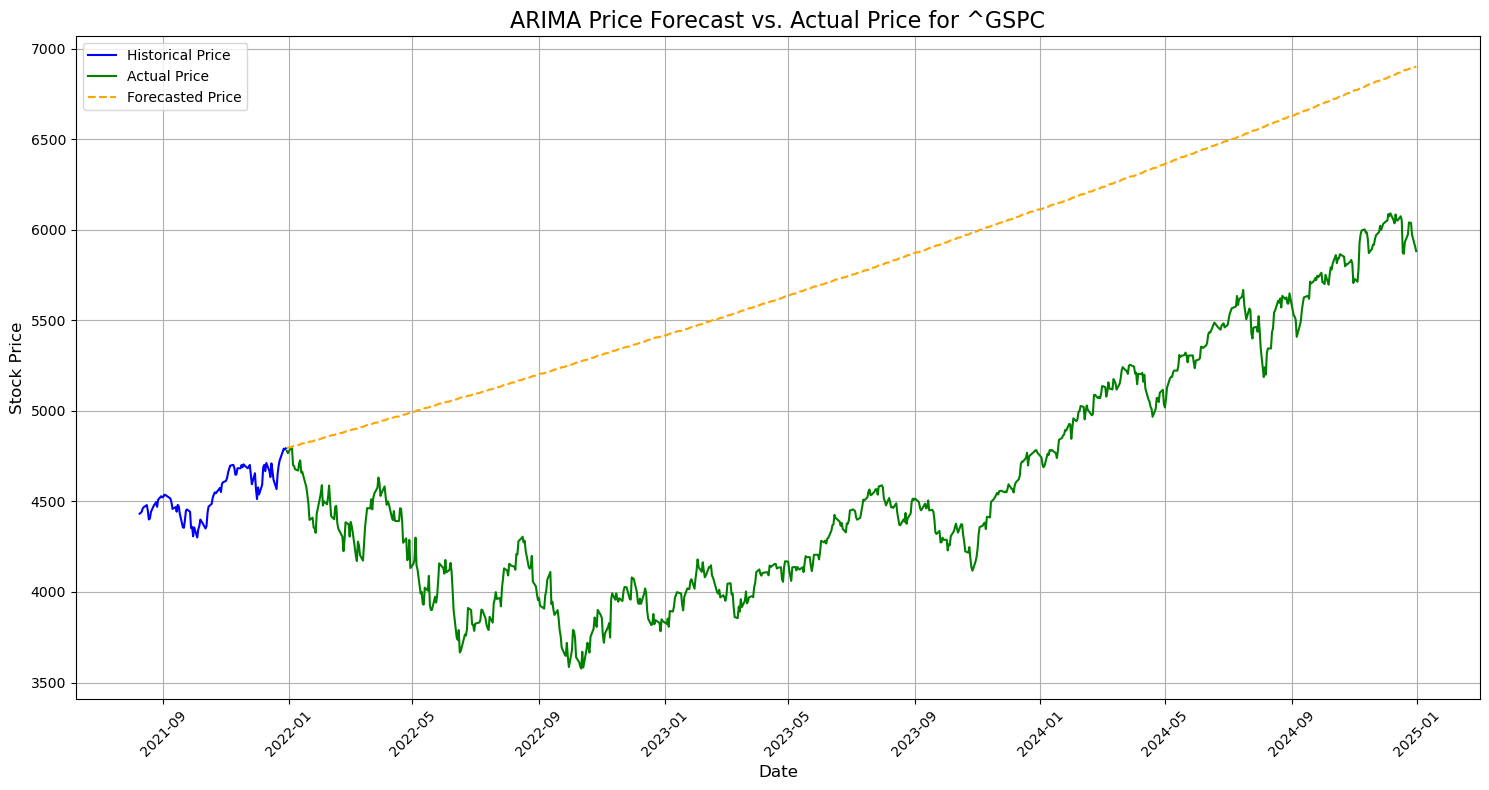

In [58]:
# We forecast for the number of steps equal to the size of our test set
forecasted_log_returns = best_model.forecast(steps=len(test_data))

# The forecast starts from the price on the last day of the training data.
last_train_index = train_data.index[-1]
last_known_price = stock_data.loc[last_train_index]['Close']

forecasted_prices = []
current_price = last_known_price

for log_return in forecasted_log_returns:
    # Reverse the log return formula: Price_t = Price_{t-1} * e^(log_return_t)
    current_price = current_price * np.exp(log_return)
    forecasted_prices.append(current_price)

# It's crucial to use the index of your `test_data` so the dates align for plotting.
forecast_price_series = pd.Series(forecasted_prices, index=test_data.index)

plt.figure(figsize=(15, 8))

plt.plot(stock_data.loc[train_data.tail(100).index]['Date'], 
         stock_data.loc[train_data.tail(100).index]['Close'], 
         label='Historical Price', color='blue')

plt.plot(stock_data.loc[test_data.index]['Date'], 
         stock_data.loc[test_data.index]['Close'], 
         label='Actual Price', color='green')

# Plot the forecasted prices
plt.plot(stock_data.loc[test_data.index]['Date'], 
         forecast_price_series, 
         label='Forecasted Price', color='orange', linestyle='--')

plt.title(f'ARIMA Price Forecast vs. Actual Price for {input_ticker}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
plt.show()

Analysis and Interpretation of the ARIMA Forecast

This chart displays the result of applying an ARIMA model to forecast the S&P 500 index (^GSPC) over a multi-year test period. The model was trained on historical log returns and then used to predict future prices.

The analysis of the forecast reveals a critical insight into the nature of ARIMA models:

1. Capturing Long-Term Drift: The forecast (the orange dashed line) successfully identifies the small, positive long-term drift inherent in the historical stock market data. By compounding this average positive return over time, the model predicts a smooth, steady increase in the index level. This indicates the model correctly understands the market's general historical tendency to appreciate over long horizons.

2. Inability to Predict Volatility and Turning Points: The most significant observation is the model's complete failure to capture any of the real-world volatility, including the major market downturn in 2022 and the subsequent recovery. The forecast is a straight-line extrapolation, demonstrating that ARIMA models, being purely statistical and backward-looking, have no mechanism to anticipate major trend changes driven by external economic factors (e.g., inflation, interest rate hikes, changing market sentiment).

Conclusion: This exercise is a powerful demonstration of both the capabilities and, more importantly, the limitations of using a simple ARIMA model for long-range financial forecasting. While useful for understanding the statistical properties (like autocorrelation) of a time series and for very short-term predictions (e.g., 1-5 days), ARIMA is not suited for predicting complex, dynamic price paths over extended periods. The result is not an error in the model's implementation but rather an accurate reflection of the model's inherent constraints. This highlights the need for more complex models (such as GARCH for volatility or machine learning models with external features) for more sophisticated market prediction tasks.